<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_5_%E6%AD%A3%E8%A6%8F%E5%8C%96%E6%B5%81_%E5%A4%89%E5%88%86%E6%8E%A8%E8%AB%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

In [ ]:
import torch
import pyro
from pyro import distributions
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions.transforms as T
from pyro.optim import Adam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


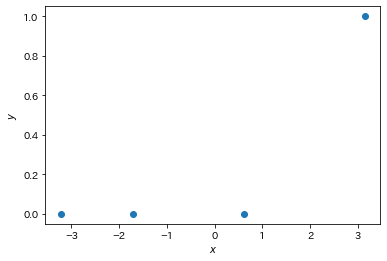

In [ ]:
torch.manual_seed(20)

# データ数
N=4
# 説明変数のサンプル
x_data = torch.distributions.uniform.Uniform(-5, 5).sample([N, 1]) 

# トイデータの生成関数
def data_generation_process(x): 
    bias = torch.ones_like(x)
    x_with_bias = torch.cat([x, bias], axis=1)
    w =  pyro.sample('w', distributions.Normal(torch.tensor([0.0, 0.0]), torch.tensor([5.0, 5.0])).to_event(1))
    sigmoid = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double())) 
    dist = distributions.Bernoulli(sigmoid)
    return dist

# 目的変数のサンプル
y_data = data_generation_process(x_data).sample()

plt.scatter(x=x_data, y=y_data);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


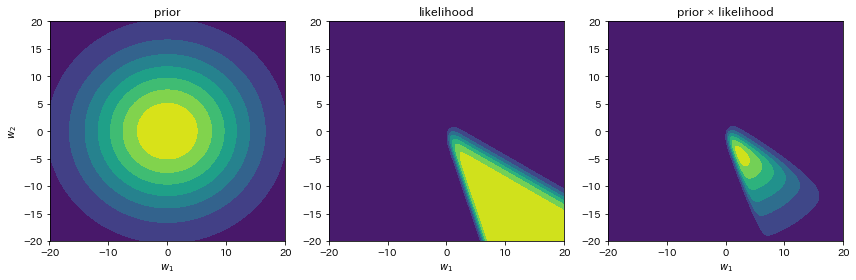

In [ ]:
# 対数のlogprobを計算する関数
def log_p_y_z(w, x, y):
    bias = torch.ones_like(x)
    x_with_bias = torch.cat([x, bias], axis=1)
    sig = torch.sigmoid(torch.matmul(torch.tensor(x_with_bias).double(), torch.tensor(w).double())).T 
    bern = distributions.Bernoulli(probs=sig).to_event(0)
    return torch.sum(bern.log_prob(y), axis=1)

# 事前分布のlogprobを計算する関数
def log_prob_w(w):
    norm = distributions.Normal(loc=torch.tensor([0.0,0.0]), scale=torch.tensor([10.0,10.0])).to_event(1)
    return norm.log_prob(w.T)

# 二次元のパラメータの格子点
plot_num=300
max_grid = 20
w1 = torch.linspace(-max_grid, max_grid, plot_num)
w2 = torch.linspace(-max_grid, max_grid, plot_num)
W1_grid, W2_grid = torch.meshgrid(w1, w2)
W12_grid = torch.tensor([[w1,w2] for w1, w2 in zip(W1_grid.ravel(), W2_grid.ravel())]).T

# 事前分布のlogprob
log_prior = log_prob_w(W12_grid).reshape(plot_num, plot_num)
# 尤度のlogprob
log_likelihoods = log_p_y_z(W12_grid, x_data, y_data).reshape(plot_num, plot_num)

fig, ax = plt.subplots(figsize=(12,4), ncols=3)
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior))
ax[0].set_title('prior')
ax[1].contourf(W1_grid, W2_grid, torch.exp(log_likelihoods))
ax[1].set_title('likelihood')
ax[2].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[2].set_title('prior × likelihood')
for i in range(3):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
plt.tight_layout();

In [ ]:
# Pyroのパラメータ初期化
pyro.clear_param_store()

# Pyroのパラメータとして登録する関数
def register_pyro_module(flows, N_flows):
    for i in range(N_flows):
        nf_module = pyro.module(f"flow_{i}", flows[i])

# 次元数
dim = 2
# 変換前のガウス分布
base_dist = distributions.Normal(torch.zeros(dim), torch.ones(dim))

# 変換の回数
N_flows = 10
# 平面流による正規化流
flows = []
for _ in range(N_flows):
    flow = T.Planar(input_dim=dim)
    flows.append(flow)
# 正規化流によって変換された確率分布
guide_NF_dist = distributions.TransformedDistribution(base_dist, flows)

# 変分推論で使用する近似分布
def guide_NF(x, y):
    register_pyro_module(flows, N_flows)
    pyro.sample("w", guide_NF_dist)

# ロジスティック回帰モデルの生成過程    
def model(x, y): 
     bias = torch.ones_like(x)
     x_with_bias = torch.cat([x, bias], axis=1)
     w =  pyro.sample('w', distributions.Normal(torch.tensor([0.0, 0.0]), torch.tensor([10.0, 10.0])).to_event(1))
        
     with pyro.plate("data", x.shape[0]):
        sigmoid = torch.sigmoid(torch.matmul(x_with_bias, w))
        obs = pyro.sample('obs', distributions.Bernoulli(sigmoid), obs=y)

In [ ]:
# 最適化アルゴリズムの設定
optimizer = Adam({"lr": 0.005})

# 変分推論の設定
svi = SVI(model, guide_NF, optimizer, loss=Trace_ELBO(num_particles=3))

torch.manual_seed(0)
# 最適化ステップ
n_steps = 20000
loss_list = []
for step in range(n_steps):
    # 変分パラメータの最適化と損失関数の計算
    loss = svi.step(x_data, y_data) 
    loss_list.append(loss)

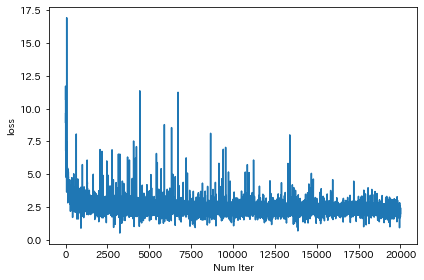

In [ ]:
# 損失関数の可視化
plt.plot(loss_list)
plt.xlabel('Num Iter')
plt.ylabel('loss')
plt.tight_layout();

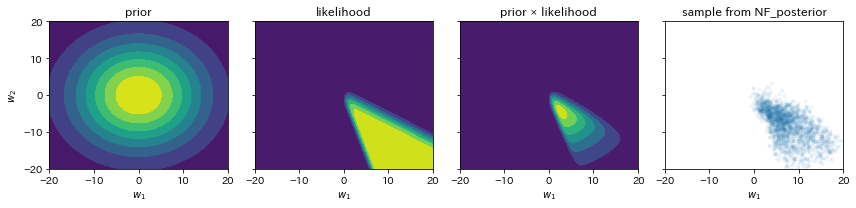

In [ ]:
fig, ax = plt.subplots(figsize=(12,3), ncols=4, sharex=True, sharey=True)
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior))
ax[0].set_title('prior')
ax[1].contourf(W1_grid, W2_grid, torch.exp(log_likelihoods))
ax[1].set_title('likelihood')
ax[2].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[2].set_title('prior × likelihood')
nf_dist_opt_samples = guide_NF_dist.sample(torch.Size([2000])).numpy()
ax[3].scatter(x=nf_dist_opt_samples[:,0], y=nf_dist_opt_samples[:,1],marker='.', alpha=0.05)
ax[3].set_title('sample from NF_posterior')

for i in range(4):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
ax[0].set_xlim(-20, 20);ax[0].set_ylim(-20, 20)
plt.tight_layout();

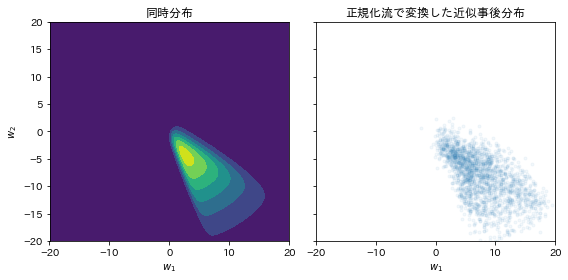

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), ncols=2, sharex=True, sharey=True)
# 同時分布の可視化
ax[0].contourf(W1_grid, W2_grid, torch.exp(log_prior+log_likelihoods))
ax[0].set_title('同時分布')

# 正規化流による変分推論をした近似事後分布からのサンプル
nf_samples = guide_NF_dist.sample(torch.Size([2000])).numpy()
ax[1].scatter(x=nf_samples[:,0], y=nf_samples[:,1],marker='.', alpha=0.05)
ax[1].set_title('正規化流で変換した近似事後分布')

for i in range(2):
  ax[i].set_xlabel(r'$w_1$')
ax[0].set_ylabel(r'$w_2$')
ax[0].set_xlim(-20, 20);ax[0].set_ylim(-20, 20)
plt.tight_layout();

In [ ]:
%load_ext watermark
%watermark --iversions

numpy              : 1.21.6
arviz              : 0.12.1
torch              : 1.11.0+cu113
scipy              : 1.4.1
pandas             : 1.3.5
pyro               : 1.8.1
IPython            : 5.5.0
seaborn            : 0.11.2
japanize_matplotlib: 1.1.3
matplotlib         : 3.2.2

